# Notice
训练之前请确保，特征模型训练后得到的 **`autoregression_feature_extractor_model.pt`** 和 **`autoregression_timeseries_data_scaler.save`** 这两个文件存在

且训练参数与本笔记本中的参数保持一致


# 导入依赖库，定义参数

In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import io
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import matplotlib.pyplot as plt


# 生成原始数据的参数
DATASET_PATH = 'UMAFall_Dataset'
WINDOW_SECONDS = 4
STEP_SECONDS = 1 # 1秒步长

# 生成上下文数据集的参数
SEQUENCE_LENGTH = 4  # 每个序列包含x个WINDOW_SIZE
STRIDE = 2           # 每隔x个WINDOW_SIZE创建一个新的序列

PRETRAINED_ENCODER_PATH = 'autoregression_feature_extractor_model.pt'
SCALER_PATH = "autoregression_timeseries_data_scaler.save"


# 处理原始数据

In [2]:
DATASEQ_PATH = f'SensorDataSequences_UMAFall_IDs1234and0_20Hz_{WINDOW_SECONDS}s.npy'
LABELSEQ_PATH = f'SensorLabelSequences_UMAFall_IDs1234and0_20Hz_{WINDOW_SECONDS}s.npy'

if os.path.exists(DATASEQ_PATH) and os.path.exists(LABELSEQ_PATH):
    print("Found existing npy files. Loading...")
    SensorDataSequences = np.load(DATASEQ_PATH)
    print(f"Loaded dataset shape: X={SensorDataSequences.shape}")
    SensorLabelSequences = np.load(LABELSEQ_PATH)
    print(f"Loaded dataset shape: y={SensorLabelSequences.shape}")
else:
    print("Npy files not found. Please run the data preprocessing script to generate the dataset.")

Found existing npy files. Loading...
Loaded dataset shape: X=(5596, 80, 48)
Loaded dataset shape: y=(5596,)


### 生成连续的特征流和标签流

In [3]:
# 如果all_features.npy和all_labels.npy已经存在，且all_features.npy大小小于2GB，则直接加载并跳过后续处理
if os.path.exists("all_features.npy") and os.path.exists("all_labels.npy") and os.path.getsize("all_features.npy") < 2 * 1024**3:
    print(f"已加载现有的特征文件 'all_features.npy' 和标签文件 'all_labels.npy'，且大小符合要求。跳过后续处理。")
    print(f"Shape of loaded features: {np.load('all_features.npy').shape}")
    print(f"Shape of loaded labels: {np.load('all_labels.npy').shape}")
else:
    raise RuntimeError("请先运行 autoregression_feature_extract.ipynb 生成特征及其标签，并检查特征维度，然后再运行此脚本。")

已加载现有的特征文件 'all_features.npy' 和标签文件 'all_labels.npy'，且大小符合要求。跳过后续处理。
Shape of loaded features: (5596, 64)
Shape of loaded labels: (5596,)


### 稀疏化数据

In [4]:
def create_sparse_data(data_array, sparsity_ratio):
    """
    Randomly sets a portion of samples in a data array to zero.

    Args:
        data_array (np.ndarray): The input data array, e.g., shape (9491, 200, 11).
        sparsity_ratio (float): The fraction of samples to set to zero (between 0.0 and 1.0).

    Returns:
        np.ndarray: A new data array with the specified portion of samples zeroed out.
    """
    if not 0.0 <= sparsity_ratio <= 1.0:
        raise ValueError("Sparsity ratio must be between 0.0 and 1.0")

    # 创建一个副本以避免修改原始数组
    sparse_array = data_array.copy()
    
    # 获取样本总数
    num_samples = sparse_array.shape[0]
    
    # 计算需要置零的样本数量
    num_to_zero_out = int(num_samples * sparsity_ratio)
    
    if num_to_zero_out == 0:
        print("Sparsity ratio is too low, no samples will be zeroed out.")
        return sparse_array

    # 随机选择不重复的索引进行置零
    indices_to_zero = np.random.choice(
        np.arange(num_samples), 
        size=num_to_zero_out, 
        replace=False
    )
    
    # 将选定索引对应的整个 (200, 11) 向量置零
    sparse_array[indices_to_zero] = 0
    
    print(f"Sparsification complete:")
    print(f"  - Total samples: {num_samples}")
    print(f"  - Sparsity ratio: {sparsity_ratio:.2f}")
    print(f"  - Samples zeroed out: {len(indices_to_zero)}")
    
    return sparse_array

# 模型定义

### 时间分布解码器

In [5]:
class TimeDistributedEncoder(nn.Module):
    def __init__(self, module):
        super(TimeDistributedEncoder, self).__init__()
        self.module = module  # module 将是一个Encoder实例

    def forward(self, x):
        # x shape: (batch_size, time_steps, window_size, num_features) e.g., (32, 8, 200, 11)
        batch_size, time_steps, seq_len, n_features = x.size()

        # 将 batch 和 time_steps 维度合并，以适配Encoder的输入
        x_reshape = x.contiguous().view(batch_size * time_steps, seq_len, n_features)
        
        # 通过Encoder，得到hidden state
        hidden, _ = self.module(x_reshape)
        # hidden shape: (num_layers, batch_size * time_steps, hidden_dim)

        # 只使用最后一层的hidden state作为该时间步的特征
        output_features = hidden[-1]
        # output_features shape: (batch_size * time_steps, hidden_dim)

        # 将维度恢复成 (batch_size, time_steps, feature_dim)
        y = output_features.view(batch_size, time_steps, -1)
        
        return y

### 交叉注意力模块

In [6]:
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query_layer = nn.Linear(query_dim, hidden_dim)
        self.key_layer = nn.Linear(key_dim, hidden_dim)
        self.value_layer = nn.Linear(key_dim, hidden_dim)
        self.scale = hidden_dim ** -0.5

    def forward(self, query, key, value):
        # query (来自LFS): (Batch, SeqLen, query_dim)
        # key/value (来自HFS): (Batch, SeqLen, key_dim)
        
        Q = self.query_layer(query)
        K = self.key_layer(key)
        V = self.value_layer(value)
        
        # 计算注意力分数
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attention_weights = torch.softmax(attention_scores, dim=-1)
        
        # 应用权重
        context_vector = torch.matmul(attention_weights, V)
        return context_vector

### 自回归Encoder模型

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        outputs, (hidden, cell) = self.lstm(x)
        # 返回最终的 hidden 和 cell 状态
        return hidden, cell

### 最终模型

In [8]:
class ContextualFidelityModel(nn.Module):
    # 参数名修改得更清晰
    def __init__(self, lfs_feature_dim, lstm_hidden_dim, hfs_feature_dim, num_classes=1, pretrained_encoder_path=None):
        super(ContextualFidelityModel, self).__init__()

        # --- HFS 处理器: 使用新的Encoder模型 ---
        # 注意：这里的参数(如hidden_dim)需要与训练Encoder时一致
        hfs_encoder = Encoder(input_dim=48, hidden_dim=hfs_feature_dim, n_layers=2, dropout=0.1)

        # --- 加载预训练的Encoder权重 ---
        if pretrained_encoder_path:
            print(f"\nAttempting to load pretrained encoder weights from: {pretrained_encoder_path}")
            if not os.path.exists(pretrained_encoder_path):
                raise FileNotFoundError(f"Pretrained encoder model file not found at '{pretrained_encoder_path}'")
            
            # 加载完整的自回归模型 state_dict
            full_state_dict = torch.load(pretrained_encoder_path, map_location=torch.device('cpu'))
            
            # 创建一个新的字典，只包含Encoder的权重
            encoder_state_dict = {}
            for key, value in full_state_dict.items():
                if key.startswith('encoder.'):
                    # 移除 'encoder.' 前缀 (e.g., 'encoder.lstm.weight' -> 'lstm.weight')
                    new_key = key[len('encoder.'):] 
                    encoder_state_dict[new_key] = value
            
            if not encoder_state_dict:
                raise ValueError(f"Could not find any keys with 'encoder.' prefix in '{pretrained_encoder_path}'. Check the saved model keys.")

            # 将筛选后的权重加载到HFS的Encoder中
            hfs_encoder.load_state_dict(encoder_state_dict)
            print("Successfully loaded pretrained weights into the HFS encoder.")
        else:
            print("\nWarning: No pretrained encoder path provided. The HFS encoder will be trained from scratch.")
        
        self.hfs_processor = TimeDistributedEncoder(hfs_encoder)

        self.lfs_processor = nn.LSTM(
            input_size=lfs_feature_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.5
        )

        # --- 交叉注意力: key_dim现在是HFS Encoder的输出维度 ---
        self.cross_attention = CrossAttention(
            query_dim=lstm_hidden_dim,
            key_dim=hfs_feature_dim, # 维度变为64
            hidden_dim=lstm_hidden_dim
        )
        
        # --- 后融合处理器与分类器 ---
        # 将 LSTM 的输出和注意力机制的输出结合起来
        self.post_fusion_processor = nn.LSTM(
            input_size=lstm_hidden_dim * 2, # Concatenated input
            hidden_size=lstm_hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, feature_sequence, imputed_raw_sequence):
        # feature_sequence: (B, 60, 6400)
        # imputed_raw_sequence: (B, 60, 200, 11)

        # 1. 并行处理两条流
        lfs_output, _ = self.lfs_processor(feature_sequence) # -> (B, 60, lstm_hidden_dim)
        hfs_output = self.hfs_processor(imputed_raw_sequence) # -> (B, 60, raw_cnn_output_dim)

        # 2. 交叉注意力融合
        # lfs_output 作为 Query，去查询 hfs_output
        attention_context = self.cross_attention(
            query=lfs_output, 
            key=hfs_output, 
            value=hfs_output
        ) # -> (B, 60, lstm_hidden_dim)
        
        # 3. 结合 LFS 输出和注意力上下文
        combined_features = torch.cat([lfs_output, attention_context], dim=-1)
        # -> (B, 60, lstm_hidden_dim * 2)

        # 4. 后融合处理与最终裁决
        final_sequence, (h_n, _) = self.post_fusion_processor(combined_features)
        
        # 使用序列的最后一个时间点的输出进行分类
        last_step_output = final_sequence[:, -1, :]
        logits = self.classifier(last_step_output)
        
        # 状态特征依然是最后一个LSTM的隐藏状态
        state_feature = h_n.squeeze(0) # -> (B, lstm_hidden_dim)

        return logits, state_feature

### 定义 PyTorch Dataset

In [9]:
class ContextualFidelityDataset(Dataset):
    """
    Custom PyTorch Dataset to create sequences for the ContextualFidelityModel.
    
    Args:
        features (np.ndarray): The array of pre-extracted features.
        raw_data (np.ndarray): The array of raw sensor data windows.
        labels (np.ndarray): The array of labels.
        sequence_length (int): The number of time steps in each sequence (e.g., 4).
        stride (int): The step size to slide the window across the data. 
                      A stride of 1 creates maximum overlap, while a stride equal 
                      to sequence_length creates no overlap.
    """
    def __init__(self, features, raw_data, labels, sequence_length=4, stride=1):
        self.features = features
        self.labels = labels
        self.sequence_length = sequence_length
        self.stride = stride
        self.raw_data = raw_data

        # 计算并存储数据集的有效长度
        self.num_sequences = (len(self.features) - self.sequence_length) // self.stride + 1

    def __len__(self):
        # 返回预先计算好的序列总数
        return self.num_sequences

    def __getitem__(self, idx):
        # 1. 根据序列索引(idx)和步长(stride)计算在原始数据中的起始位置
        start_idx = idx * self.stride
        end_idx = start_idx + self.sequence_length

        # 2. 切片特征和原始数据
        feature_seq = self.features[start_idx:end_idx]
        raw_seq = self.raw_data[start_idx:end_idx]
        
        # 3. 应用新的标签生成规则
        #   - 切片这个序列对应的所有标签
        label_slice = self.labels[start_idx:end_idx]
        #   - 如果这个切片中任何一个标签为1，则最终标签为1，否则为0。
        #     这等同于取这个切片中的最大值。
        label = np.max(label_slice)

        # 转换为Tensors
        feature_seq_tensor = torch.tensor(feature_seq, dtype=torch.float32)
        raw_seq_tensor = torch.tensor(raw_seq, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(-1)

        return feature_seq_tensor, raw_seq_tensor, label_tensor

### 加载，分割，创建DataLoader

In [10]:
print("--- Starting Data Preparation ---")

# 定义常量
BATCH_SIZE = 32
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.15

if not os.path.exists("all_features.npy") or not os.path.exists("all_labels.npy"):
    print("File 'all_features.npy' or 'all_labels.npy' not found. Exiting.")
    raise FileNotFoundError("Required data files are missing.")


# 加载数据集
final_features = np.load("all_features.npy")
final_labels = np.load("all_labels.npy")

# 归一化
print("\nApplying scaler to raw sensor data sequences...")
scaler = joblib.load(SCALER_PATH)

raw_windows_original = []
for i in range(SensorDataSequences.shape[0]):
    scaled_sequence = scaler.transform(SensorDataSequences[i])
    raw_windows_original.append(scaled_sequence)

print("Finished applying scaler to raw sensor data sequences.")

# 数据稀疏化
SPARSITY_RATIO = 0.1
raw_windows = create_sparse_data(np.array(raw_windows_original), SPARSITY_RATIO)
# 不使用稀疏化
# raw_windows = raw_windows_original


print(f"Dataset Hyperparameters:")
print(f"  - Sequence Length (time_steps): {SEQUENCE_LENGTH}")
print(f"  - Stride: {STRIDE}")

# 创建 Dataset 实例
full_dataset = ContextualFidelityDataset(
    features=final_features, 
    raw_data=raw_windows, 
    labels=final_labels, 
    sequence_length=SEQUENCE_LENGTH, 
    stride=STRIDE
)

# 打印数据集大小变化以作验证
original_len = len(final_features) - SEQUENCE_LENGTH + 1
new_len = len(full_dataset)
print(f"\nDataset size changed:")
print(f"  - Original size (stride=1): {original_len} sequences")
print(f"  - New augmented size (stride={STRIDE}): {new_len} sequences")
print(f"  - Augmentation factor: {new_len / original_len:.2f}x")


# 创建训练、验证和测试集的索引
dataset_indices = list(range(len(full_dataset)))
train_val_indices, test_indices = train_test_split(dataset_indices, test_size=TEST_SIZE, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=VALIDATION_SIZE / (1 - TEST_SIZE), random_state=42)

# 创建训练、验证和测试集的子集
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

--- Starting Data Preparation ---

Applying scaler to raw sensor data sequences...
Finished applying scaler to raw sensor data sequences.
Sparsification complete:
  - Total samples: 5596
  - Sparsity ratio: 0.10
  - Samples zeroed out: 559
Dataset Hyperparameters:
  - Sequence Length (time_steps): 4
  - Stride: 2

Dataset size changed:
  - Original size (stride=1): 5593 sequences
  - New augmented size (stride=2): 2797 sequences
  - Augmentation factor: 0.50x
Training samples: 1817
Validation samples: 420
Test samples: 560


# 训练

In [11]:
print("\n--- Model Training and Evaluation ---")

LFS_FEATURE_DIM = final_features.shape[1] 

# HFS特征维度由Encoder的hidden_dim决定
HFS_FEATURE_DIM = 64 

if HFS_FEATURE_DIM != LFS_FEATURE_DIM:
    raise RuntimeError(f"HFS feature dimension ({HFS_FEATURE_DIM}) does not match LFS feature dimension ({LFS_FEATURE_DIM}). Please check the Encoder configuration.")

LSTM_HIDDEN_DIM = 256
NUM_CLASSES = 1
LEARNING_RATE = 0.0001
EPOCHS = 15

print("\nModel Hyperparameters:")
print(f"  - LFS Feature Dimension: {LFS_FEATURE_DIM}")
print(f"  - HFS Feature Dimension: {HFS_FEATURE_DIM}")
print(f"  - LSTM Hidden Dimension: {LSTM_HIDDEN_DIM}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用新的维度参数来实例化模型
model = ContextualFidelityModel(
    lfs_feature_dim=LFS_FEATURE_DIM, 
    lstm_hidden_dim=LSTM_HIDDEN_DIM, 
    hfs_feature_dim=HFS_FEATURE_DIM, 
    num_classes=NUM_CLASSES,
    pretrained_encoder_path=PRETRAINED_ENCODER_PATH
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for feature_seq, raw_seq, labels in loader:
            feature_seq, raw_seq, labels = feature_seq.to(device), raw_seq.to(device), labels.to(device)
            
            outputs, _ = model(feature_seq, raw_seq)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1

train_losses = []
val_losses = []
val_accs = []
val_f1s = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for i, (feature_seq, raw_seq, labels) in enumerate(train_loader):
        feature_seq, raw_seq, labels = feature_seq.to(device), raw_seq.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(feature_seq, raw_seq)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Print training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on validation set
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

print("\nTraining finished.")

# Save the trained model
torch.save(model.state_dict(), 'UMAFall_contextual_fidelity_model_pretrained_encoder.pth')

# --- 4. Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


--- Model Training and Evaluation ---

Model Hyperparameters:
  - LFS Feature Dimension: 64
  - HFS Feature Dimension: 64
  - LSTM Hidden Dimension: 256

Attempting to load pretrained encoder weights from: autoregression_feature_extractor_model.pt
Successfully loaded pretrained weights into the HFS encoder.
Epoch [1/15] | Train Loss: 0.6311 | Val Loss: 0.5133 | Val Acc: 0.7500 | Val F1: 0.0000
Epoch [2/15] | Train Loss: 0.3512 | Val Loss: 0.1980 | Val Acc: 0.9667 | Val F1: 0.9320
Epoch [3/15] | Train Loss: 0.1552 | Val Loss: 0.1081 | Val Acc: 0.9762 | Val F1: 0.9519
Epoch [4/15] | Train Loss: 0.0824 | Val Loss: 0.0794 | Val Acc: 0.9786 | Val F1: 0.9565
Epoch [5/15] | Train Loss: 0.0632 | Val Loss: 0.0714 | Val Acc: 0.9786 | Val F1: 0.9565
Epoch [6/15] | Train Loss: 0.0507 | Val Loss: 0.0722 | Val Acc: 0.9810 | Val F1: 0.9612
Epoch [7/15] | Train Loss: 0.0401 | Val Loss: 0.0712 | Val Acc: 0.9810 | Val F1: 0.9612
Epoch [8/15] | Train Loss: 0.0296 | Val Loss: 0.0680 | Val Acc: 0.9810 | V

## 训练指标图像

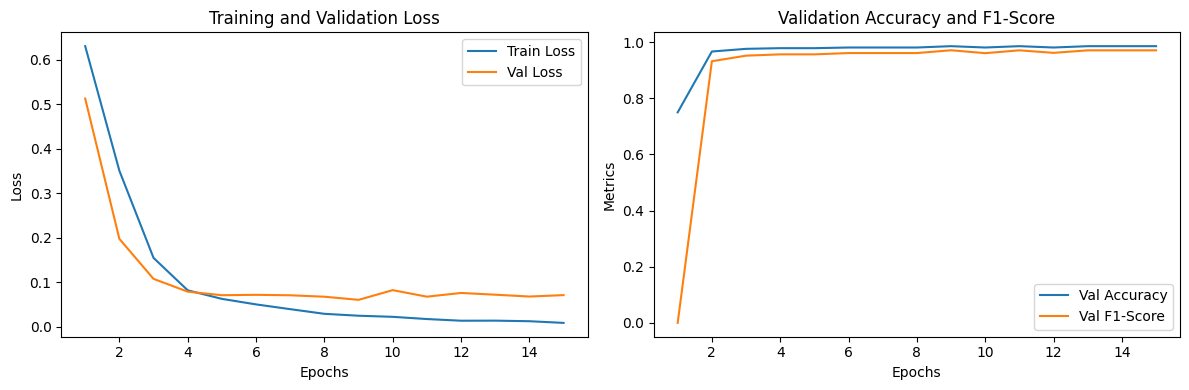

In [12]:
# 绘制训练指标图
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.plot(epochs_range, val_f1s, label='Val F1-Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Accuracy and F1-Score')
plt.legend()
plt.tight_layout()
plt.show()